In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Download data
ticker = "IRFC.NS"  # Adjust the ticker as per the Yahoo Finance listing
start_date = '2022-04-01'
end_date = '2024-03-31'

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
returns = 100 * data['Adj Close'].pct_change().dropna()  # Calculate returns

In [4]:
# Display the first few rows of the data
print(data.head())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2022-04-01  21.400000  21.600000  21.350000  21.500000  19.896145  10607411
2022-04-04  21.600000  21.850000  21.549999  21.650000  20.034954  13261803
2022-04-05  21.650000  22.299999  21.650000  22.150000  20.497658   8377562
2022-04-06  22.049999  22.299999  22.000000  22.100000  20.451387   6691801
2022-04-07  22.200001  22.350000  22.150000  22.299999  20.636465   6164467


In [5]:
# Calculate returns
data['Return'] = 100 * data['Adj Close'].pct_change().dropna()  # Calculate returns
data = data.dropna()  # Drop rows with NaN values resulting from pct_change()

In [6]:
# Check for ARCH effects using the Ljung-Box test on squared returns
lb_test = sm.stats.diagnostic.acorr_ljungbox(data['Return']**2, lags=[10], return_df=True)
print('Ljung-Box test for ARCH effects:')
print(lb_test)

Ljung-Box test for ARCH effects:
      lb_stat  lb_pvalue
10  33.443798   0.000229


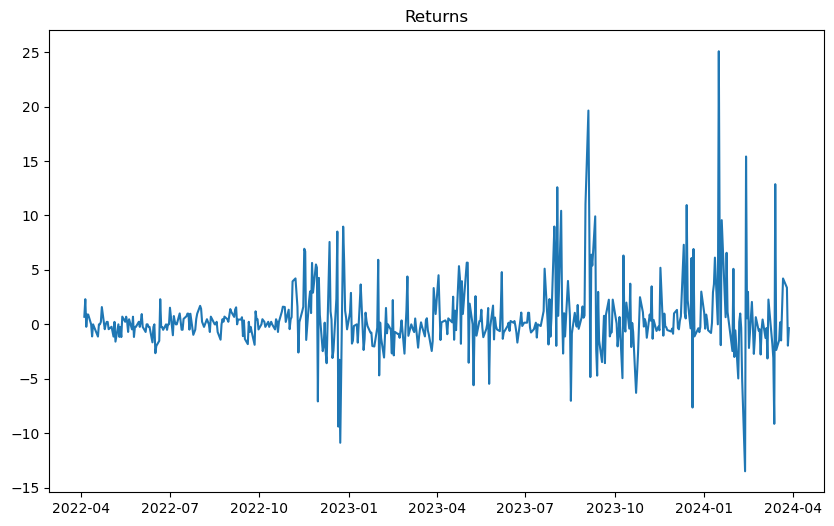

In [7]:
# Check for ARCH/GARCH effects
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.title('Returns')
plt.show()

In [8]:
# Fit an ARCH model
model = arch_model(returns, vol='ARCH', p=2, q=1)
results = model.fit(disp='off')
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1149.45
Distribution:                  Normal   AIC:                           2306.90
Method:            Maximum Likelihood   BIC:                           2323.69
                                        No. Observations:                  491
Date:                Fri, Jul 26 2024   Df Residuals:                      490
Time:                        15:21:52   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0163      0.135     -0.120      0.904 [ -0.282,  0.24

In [9]:
# Fit an GARCH model
model = arch_model(returns, vol='GARCH', p=1, q=1)
results = model.fit(disp='off')
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1135.64
Distribution:                  Normal   AIC:                           2279.28
Method:            Maximum Likelihood   BIC:                           2296.07
                                        No. Observations:                  491
Date:                Fri, Jul 26 2024   Df Residuals:                      490
Time:                        15:21:52   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0102      0.124 -8.209e-02      0.935 [ -0.254,  0.23

In [10]:
# Forecast the three-month volatility
forecast = results.forecast(horizon=90)
volatility_forecast = forecast.variance[-1:]  # Last forecasted variance
volatility_forecast = volatility_forecast.apply(lambda x: x**0.5)  # Convert to standard deviation
print(volatility_forecast)

                h.01      h.02      h.03      h.04      h.05      h.06  \
Date                                                                     
2024-03-28  2.508072  2.657748  2.799433  2.934284  3.063205  3.186914   

                h.07      h.08      h.09      h.10  ...      h.81      h.82  \
Date                                                ...                       
2024-03-28  3.305998  3.420939  3.532141  3.639948  ...  8.255083  8.301783   

                h.83      h.84      h.85      h.86      h.87      h.88  \
Date                                                                     
2024-03-28  8.348221  8.394403  8.440332  8.486012  8.531447  8.576642   

              h.89      h.90  
Date                          
2024-03-28  8.6216  8.666325  

[1 rows x 90 columns]


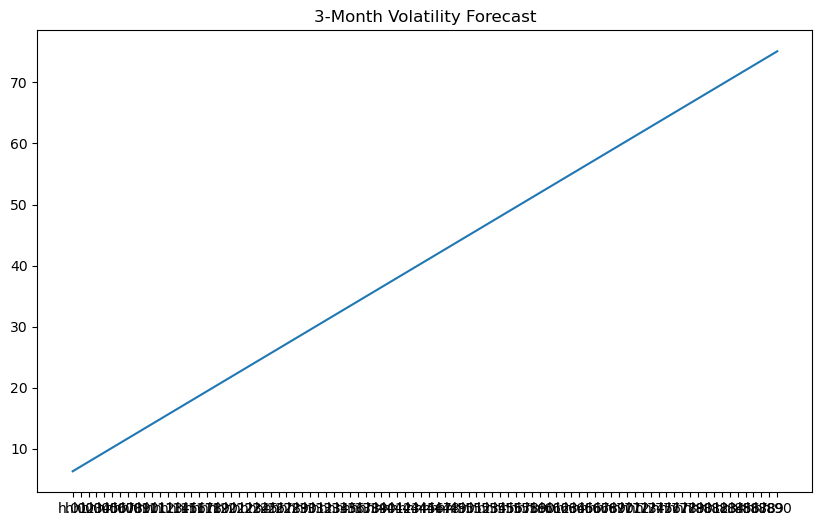

In [11]:
# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(forecast.variance[-1:].T)
plt.title('3-Month Volatility Forecast')
plt.show()

In [12]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [13]:
# Load the data
df = pd.read_excel('CMO-Historical-Data-Monthly.xlsx', sheet_name="Monthly Prices", skiprows=6)

# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

# Convert the Date column to datetime format
def parse_date(date_str):
    year, month = date_str[:4], date_str[5:7]
    return pd.to_datetime(f'{year}-{month}-01')

df['Date'] = df['Date'].apply(parse_date)

# Display the structure of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           774 non-null    datetime64[ns]
 1   CRUDE_PETRO    774 non-null    float64       
 2   CRUDE_BRENT    774 non-null    float64       
 3   CRUDE_DUBAI    774 non-null    float64       
 4   CRUDE_WTI      774 non-null    object        
 5   COAL_AUS       774 non-null    object        
 6   COAL_SAFRICA   774 non-null    object        
 7   NGAS_US        774 non-null    float64       
 8   NGAS_EUR       774 non-null    float64       
 9   NGAS_JP        774 non-null    object        
 10  iNATGAS        774 non-null    object        
 11  COCOA          774 non-null    float64       
 12  COFFEE_ARABIC  774 non-null    float64       
 13  COFFEE_ROBUS   774 non-null    float64       
 14  TEA_AVG        774 non-null    float64       
 15  TEA_COLOMBO    774 non-

In [14]:
# Get the column numbers for each column
column_numbers = {col: idx for idx, col in enumerate(df.columns)}

# Select relevant columns
commodity = df.iloc[:, [0, 62, 63, 64, 65]]

# Clean column names
commodity.columns = commodity.columns.str.lower().str.replace(' ', '_')

# Display the structure of the commodity dataframe
print(commodity.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      774 non-null    datetime64[ns]
 1   aluminum  774 non-null    float64       
 2   iron_ore  774 non-null    float64       
 3   copper    774 non-null    float64       
 4   lead      774 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 30.4 KB
None


In [15]:
# Exclude the Date column
commodity_data = commodity.drop(columns=['date'])

In [16]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

# Function to perform the ADF test and extract p-value
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-value

# Loop through each column and perform the ADF test
for col in commodity_data.columns:
    p_value = adf_test(commodity_data[col])
    print(f"\nADF test result for column: {col}\n")
    print(f"P-value: {p_value}")
    
    if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
    else:
        stationary_columns.append(col)

# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}\n")
print(f"Non-stationary columns: {non_stationary_columns}\n")
print(f"Stationary columns: {stationary_columns}")

# Co-Integration Test (Johansen's Test)
lags = 10  # Setting maximum lags
johansen_test = coint_johansen(commodity_data, det_order=0, k_ar_diff=lags)

# Determining the number of co-integrating relationships (r)
r = sum(johansen_test.lr1 > johansen_test.cvt[:, 1])  # Number of significant eigenvalues


ADF test result for column: aluminum

P-value: 0.2541613210592646

ADF test result for column: iron_ore

P-value: 0.6181188639502071

ADF test result for column: copper

P-value: 0.839312403224542

ADF test result for column: lead

P-value: 0.7371961625765219

Number of non-stationary columns: 4

Non-stationary columns: ['aluminum', 'iron_ore', 'copper', 'lead']

Stationary columns: []


Det. terms outside the coint. relation & lagged endog. parameters for equation aluminum
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.1289      4.442      1.380      0.168      -2.577      14.835
L1.aluminum      0.0645      0.041      1.564      0.118      -0.016       0.145
L1.iron_ore     -1.1435      0.639     -1.790      0.073      -2.396       0.108
L1.copper        0.0486      0.019      2.582      0.010       0.012       0.085
L1.lead          0.0070      0.049      0.144      0.886      -0.089       0.103
L2.aluminum     -0.0460      0.041     -1.123      0.262      -0.126       0.034
L2.iron_ore     -0.0408      0.660     -0.062      0.951      -1.334       1.252
L2.copper        0.0457      0.020      2.322      0.020       0.007       0.084
L2.lead         -0.0472      0.051     -0.927      0.354      -0.147       0.053
L3.aluminum      0.04

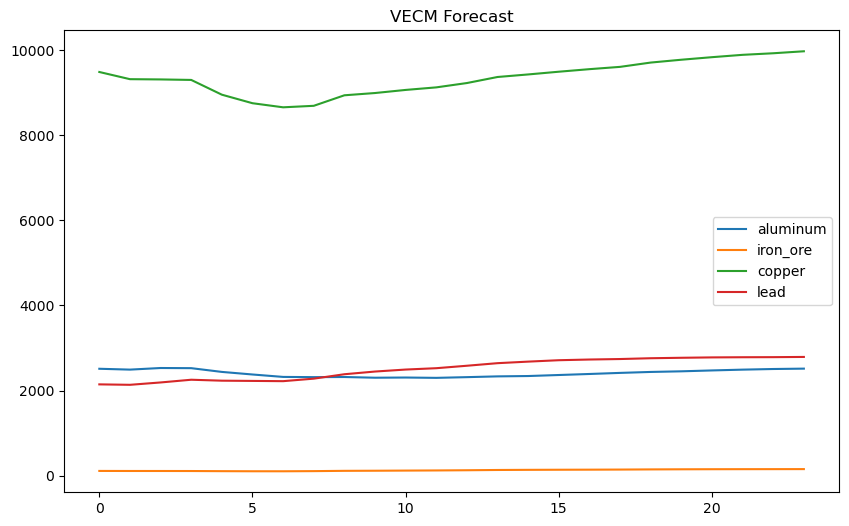

In [17]:
if r > 0:
    # If co-integration exists, estimate the VECM model
    vecm_model = VECM(commodity_data, k_ar_diff=lags, coint_rank=r, deterministic='co').fit()
    
    # Summary of the VECM model
    print(vecm_model.summary())
    
    # Creating a VAR model for prediction using the VECM
    vecm_pred = vecm_model.predict(steps=24)
    
    # Forecasting using the VECM model
    forecast = pd.DataFrame(vecm_pred, columns=commodity_data.columns)
    
    # Plotting the forecast
    forecast.plot(figsize=(10, 6))
    plt.title('VECM Forecast')
    plt.show()

else:
    # If no co-integration exists, proceed with Unrestricted VAR Analysis
    var_model = VAR(commodity_data)
    var_result = var_model.fit(maxlags=lags, ic='aic')
    
    # Summary of the VAR model
    print(var_result.summary())
    
    # Forecasting using the VAR model
    forecast = var_result.forecast(var_result.y, steps=24)
    forecast_df = pd.DataFrame(forecast, columns=commodity_data.columns)
    
    # Plotting the forecast
    forecast_df.plot(figsize=(10, 6))
    plt.title('VAR Forecast')
    plt.show()

In [18]:
forecast

,aluminum,iron_ore,copper,lead
0,2510.751538,109.846260,9485.173681,2144.035666
1,2490.815695,108.604174,9316.233424,2133.742465
2,2528.578151,108.424637,9310.302364,2189.170395
3,2525.004367,107.667688,9298.579208,2252.967650
4,2436.859142,104.386409,8951.767378,2230.761092
5,2376.273824,102.127503,8751.272107,2225.251969
6,2319.385516,101.743677,8655.169729,2219.367164
7,2313.926862,105.273150,8690.304372,2278.506287
8,2316.965964,112.100374,8937.542068,2382.129376
9,2300.486364,114.589043,8990.765266,2445.643927
